<a href="https://colab.research.google.com/github/jungo876/BengaliDigitClassifier/blob/main/BengaliDigitClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import gdown
file_id = '1hSEK19zjgB1e2RM-esoTReAqnZDtH1wD'
gdown.download(f"https://drive.google.com/uc?id={file_id}","archive (2).zip",quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1hSEK19zjgB1e2RM-esoTReAqnZDtH1wD
From (redirected): https://drive.google.com/uc?id=1hSEK19zjgB1e2RM-esoTReAqnZDtH1wD&confirm=t&uuid=821b7cf7-e0f4-450b-8bb5-6c819f94cea1
To: /content/archive (2).zip
100%|██████████| 2.06G/2.06G [00:29<00:00, 68.6MB/s]


'archive (2).zip'

In [2]:
import zipfile

with zipfile.ZipFile("archive (2).zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [3]:
csv_files = ['training-a.csv', 'training-b.csv', 'training-c.csv', 'training-d.csv', 'training-e.csv']
base_dir = 'dataset/archive (5)/'

df_list = []

for csv in csv_files:
    df = pd.read_csv(os.path.join(base_dir, csv))
    folder_name = csv.split('.')[0]  # e.g., training-a
    df['img_path'] = df['filename'].apply(lambda x: os.path.join(base_dir, folder_name, x))
    df_list.append(df[['img_path', 'digit']])

full_df = pd.concat(df_list).reset_index(drop=True)
print(full_df.shape)

(72045, 2)


In [4]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 32

X = []
y = []

for i, row in tqdm(full_df.iterrows(), total=len(full_df)):
    img = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(row['digit'])

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0  # Normalize to [0, 1]
y = np.array(y)


100%|██████████| 72045/72045 [01:03<00:00, 1138.97it/s]


In [5]:
from tensorflow.keras.utils import to_categorical

num_classes = 10
y_cat = to_categorical(y, num_classes)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2,stratify=y,random_state=42)


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [36]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

tf.random.set_seed(1234)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1),kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),


    Conv2D(32, (3,3), activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511,338 (1.95 MB)

 Trainable params: 510,186 (1.95 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [38]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), # Changed loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [39]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # reduce LR by half
    patience=2,         # after 2 epochs of no improvement
    min_lr=1e-6,        # minimum learning rate
    verbose=1
)
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks = [early_stop,lr_scheduler]
)


Epoch 1/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.1344 - loss: 2.6138 - precision_5: 0.3018 - recall_5: 0.0332 - val_accuracy: 0.2555 - val_loss: 2.5025 - val_precision_5: 0.8481 - val_recall_5: 0.1569 - learning_rate: 0.0010
Epoch 2/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.1916 - loss: 2.2170 - precision_5: 0.6887 - recall_5: 0.0733 - val_accuracy: 0.2725 - val_loss: 2.8257 - val_precision_5: 0.2685 - val_recall_5: 0.2615 - learning_rate: 0.0010
Epoch 3/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.2109 - loss: 2.1472 - precision_5: 0.7665 - recall_5: 0.0925 - val_accuracy: 0.2853 - val_loss: 2.3401 - val_precision_5: 0.9121 - val_recall_5: 0.2023 - learning_rate: 0.0010
Epoch 4/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.2213 - loss: 2.1259 - precision_5: 0.7717 - recall_5: 0.1064 - val_accuracy: 0.2831 - val_loss: 2.9917 - val_precision_5: 0.2813 - val_recall_5: 0.2775 - learning_rate: 0.0010
Epoch 5/30
900/901 ━━━━━

In [40]:
# Training and validation loss
train_loss = history.history['loss']          # J_train
val_loss = history.history['val_loss']        # J_cv

# Training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


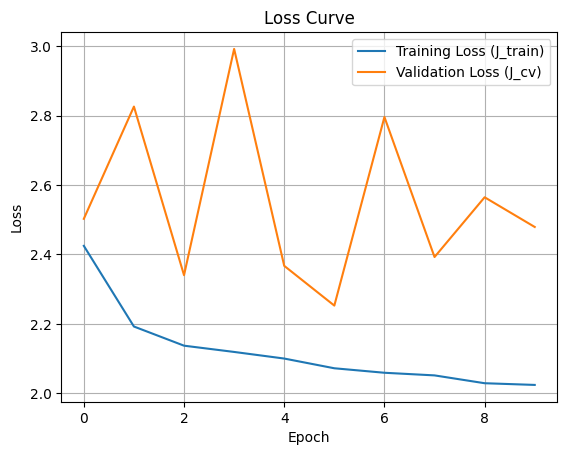

In [41]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Training Loss (J_train)')
plt.plot(val_loss, label='Validation Loss (J_cv)')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
y_pred_probs = model.predict(X_val)

451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [45]:
y_pred_labels = np.argmax(y_pred_probs, axis=1)

In [46]:
y_true_labels = np.argmax(y_val, axis=1)

In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_labels, y_pred_labels)

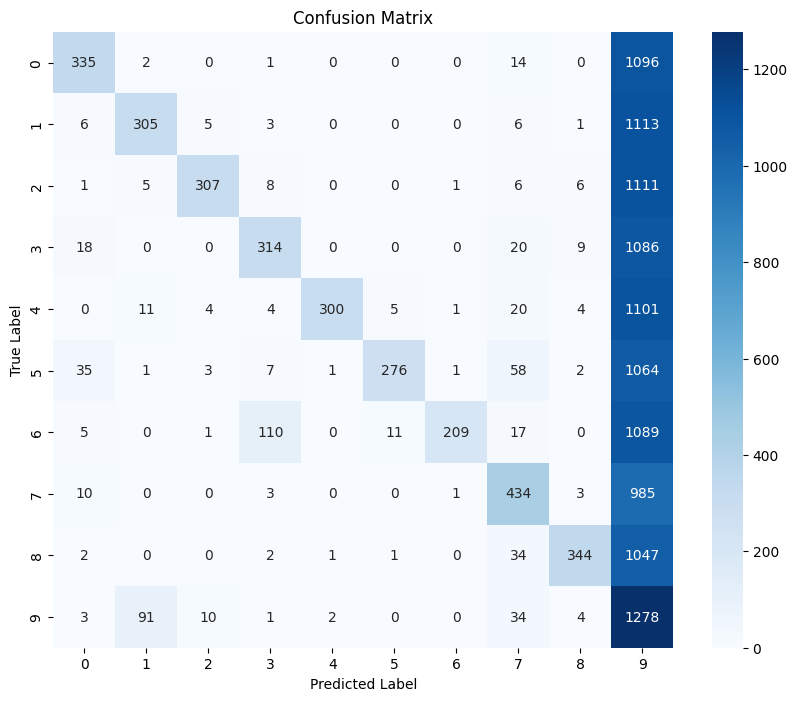

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()